In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
#box length for periodic boundary condition
#ephsilon for A-B,A-A, and B-B interaction
#sigma for A-B,A-A, and B-B interaction
#cutoff for interaction r=rc*sigma

boxLength=4.3679
εAA = 1.0 
εAB = 1.5
εBB = 0.5
σAA = 1.0
σAB = 0.8
σBB = 0.88
rc = 2.5

In [3]:
#Loading the position and type of atoms
position=torch.tensor(np.load("LJ_A80B20_3D_100_pos.npy"))
typeSpecies=torch.tensor(np.load("LJ_A80B20_3D_100_species.npy"),dtype=torch.float64)
typeSpecies=torch.where(typeSpecies==0,-1.0,1.0).double()
position=position%boxLength
#A=-1 and B=1

In [4]:
N=position.shape[0]
d=position.shape[1]


In [5]:
#pairwise lj potential
def ljp(r, epsilon=1, sigma=1):
    return  (4*epsilon*((sigma/r)**12-(sigma/r)**6))

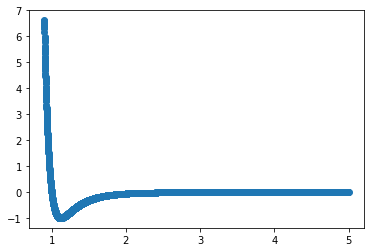

In [6]:
#plotting the above defined lj potential 
X = torch.tensor(np.random.uniform(0.9,5, 10000).reshape(-1,1))
Y= ljp(X,1, 1)
plt.scatter(X.detach().numpy(),Y.detach().numpy())

In [7]:
#total lj potential for the system
def totalPE(position):
    position=position.reshape(N,d)
    position=(position+boxLength)%boxLength
    PE=0
    cutoff=0
    for i in range(len(position)):
        for j in range(i+1,len(position)):
            r=torch.abs(position[i]-position[j])
            r=r%boxLength
            dr=torch.norm(torch.where(r>boxLength/2,boxLength-r,r))
            typeInteraction=typeSpecies[i]+typeSpecies[j]
            cutoff=torch.where(typeInteraction==0, torch.tensor(rc*σAB) ,torch.where(typeInteraction<0, torch.tensor(rc*σAA), torch.tensor(rc*σBB)))
            PE+=torch.where(dr>cutoff,0.0, torch.where(typeInteraction==0, ljp(dr,εAB,σAB),torch.where(typeInteraction<0, ljp(dr,εAA,σAA), ljp(dr,εBB,σBB))) )
    return PE

In [8]:
print("The total potential energy of the system is given by ", totalPE(position).item())

The total potential energy of the system is given by  -792.9939374989526


In [9]:
def L2norm(dk):
    return np.linalg.norm(dk)

In [10]:
#Steepest descent algorithm with the step size chose such that the function value always decreases
#if stopping criteria is changed to relative_value_change the loop will break when the l2 norm of change in x becomes less than cutoff
def ModifiedSteepestDescent(x,function_,alpha=0.1,stopping_criteria="None",cutoff=1e-20,totalEpochs=100,reducing_factor=10,verbrose=False):
    epoch=0
    f_previous_iter=function_(x)
    alpha=0.1
    function_values=[]
    function_values.append(f_previous_iter.detach().numpy())
    
    while True:
        print("Executing epoch ", epoch)
        if epoch >= totalEpochs:
            break
        
        x.requires_grad_(True)
        epoch+=1
        fx=function_(x)
        fx.backward()
        dk=x.grad

        x_= x-alpha*dk
        x_=(x_)%boxLength
        fx_ = function_(x_)    

        if (fx_ < fx):
            function_values.append(fx_.detach().numpy())
            if stopping_criteria=="relative_value_change" and (L2norm((x_-x).detach().numpy()))<cutoff:
                break
            x=x_.detach()
            continue
        else:
            alpha=alpha/reducing_factor
            if verbrose:
                print("changing alpha, present alpha is ",alpha)
        if alpha<cutoff:
            break
    return np.array(x.detach()),np.array(function_values) 

In [11]:
#Steepest descent with the general formula for alpha with quadratic approximation
def GeneralSteepestDescent(x,function_,totalEpochs=100,stopping_criteria="relative_value_change",cutoff=1e-10):
    epoch=0
    function_values=[]
    x_values=[]
    x_prev=x
    f_previous_iter=function_(x)
    alpha_start=0.1
  
    while True:
        print("Executing epoch ", epoch)
        if epoch>=totalEpochs:
            break
        x.requires_grad_(True)
        fx=function_(x)
        function_values.append(fx.detach().numpy())
        fx.backward()
        dk=x.grad

        x_= x-alpha_start*dk
        fx_ = function_(x_)
        alpha=(((dk.T@dk)*(alpha_start)**2)/(2*(fx_- fx + alpha_start*(dk.T@dk)))).detach()
        if np.isnan(alpha):
            break      
        x= x-alpha*dk
        if stopping_criteria=="relative_value_change" and (L2norm((x-x_prev).detach().numpy()))<cutoff:
            print("very low change so exiting")
            break
        alpha_start=alpha
        x=x%boxLength
        x=x.detach()
        x_prev=x
        epoch=epoch+1
    return np.array(x),np.array(function_values)

In [15]:
#starting position
start_pos=position.reshape(-1)

In [16]:
#using the Modified gradient descent
#Number of iterations
epochs=300
xOpt,functionValues=ModifiedSteepestDescent(start_pos,totalPE,totalEpochs=epochs)

Executing epoch  0
Executing epoch  1
Executing epoch  2
Executing epoch  3
Executing epoch  4
Executing epoch  5
Executing epoch  6
Executing epoch  7
Executing epoch  8
Executing epoch  9
Executing epoch  10
Executing epoch  11
Executing epoch  12
Executing epoch  13
Executing epoch  14
Executing epoch  15
Executing epoch  16
Executing epoch  17
Executing epoch  18
Executing epoch  19
Executing epoch  20
Executing epoch  21
Executing epoch  22
Executing epoch  23
Executing epoch  24
Executing epoch  25
Executing epoch  26
Executing epoch  27
Executing epoch  28
Executing epoch  29
Executing epoch  30
Executing epoch  31
Executing epoch  32
Executing epoch  33
Executing epoch  34
Executing epoch  35
Executing epoch  36
Executing epoch  37
Executing epoch  38
Executing epoch  39
Executing epoch  40
Executing epoch  41
Executing epoch  42
Executing epoch  43
Executing epoch  44
Executing epoch  45
Executing epoch  46
Executing epoch  47
Executing epoch  48
Executing epoch  49
Executing 

In [13]:
epochs=300
xOpt,functionValues=GeneralSteepestDescent(start_pos,totalPE,totalEpochs=epochs)

Executing epoch  0


/tmp/ipykernel_2460013/214948267.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  alpha=(((dk.T@dk)*(alpha_start)**2)/(2*(fx_- fx + alpha_start*(dk.T@dk)))).detach()


Executing epoch  1
Executing epoch  2
Executing epoch  3
Executing epoch  4
Executing epoch  5
Executing epoch  6
Executing epoch  7
Executing epoch  8
Executing epoch  9
Executing epoch  10
Executing epoch  11
Executing epoch  12
Executing epoch  13
Executing epoch  14
Executing epoch  15
Executing epoch  16
Executing epoch  17
Executing epoch  18
Executing epoch  19
Executing epoch  20
Executing epoch  21
Executing epoch  22
Executing epoch  23
Executing epoch  24
Executing epoch  25
Executing epoch  26
Executing epoch  27
Executing epoch  28
Executing epoch  29
Executing epoch  30
Executing epoch  31
Executing epoch  32
Executing epoch  33
Executing epoch  34
Executing epoch  35
Executing epoch  36
Executing epoch  37
Executing epoch  38
Executing epoch  39
Executing epoch  40
Executing epoch  41
Executing epoch  42
Executing epoch  43
Executing epoch  44
Executing epoch  45
Executing epoch  46
Executing epoch  47
Executing epoch  48
Executing epoch  49
Executing epoch  50
Executing

Text(0, 0.5, 'Function value')

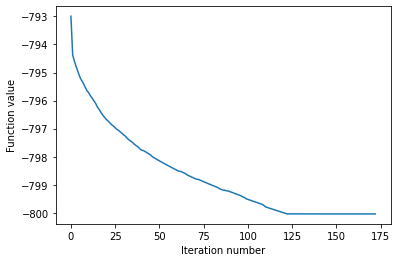

In [17]:
plt.plot(functionValues)
plt.xlabel("Iteration number")
plt.ylabel("Function value")